In [2]:
import json
from dotenv import load_dotenv
load_dotenv(".env", override = True)

True

In [3]:
import aisuite as ai

client = ai.Client()

In [4]:
from datetime import datetime

def get_current_time():
    """
    Returns the current time as a string.
    """
    return datetime.now().strftime("%H:%M:%S")

In [5]:
get_current_time()

'14:22:47'

In [6]:
# Message structure
prompt = "What time is it?"
messages = [
    {
        "role": "user",
        "content": prompt,
    }
]

In [7]:
response = client.chat.completions.create(
    model="openai:gpt-4o",
    messages=messages,
    tools=[get_current_time],
    max_turns=5 # max_turns, is used only when you include tools (a.k.a. function calls)

)

# When a tool (like your get_current_time) is defined, the model can decide to call the tool multiple times in a reasoning chain before producing its final text output.

# max_turns limits how many back-and-forth exchanges between the model and the tool are allowed within a single .create() call.

In [8]:
response.choices[0].message.content

'The current time is 14:24:52.'

In [11]:
choice = response.choices[0]

In [12]:
choice

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The current time is 14:24:52.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None), intermediate_messages=[ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageFunctionToolCall(id='call_z4LK1qPTCxF75rQkru44VNmu', function=Function(arguments='{}', name='get_current_time'), type='function')]), {'role': 'tool', 'name': 'get_current_time', 'content': '"14:24:52"', 'tool_call_id': 'call_z4LK1qPTCxF75rQkru44VNmu'}, ChatCompletionMessage(content='The current time is 14:24:52.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None)])

In [13]:
intermediate_messages = getattr(choice, "intermediate_messages", [])

In [14]:
intermediate_messages

[ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageFunctionToolCall(id='call_z4LK1qPTCxF75rQkru44VNmu', function=Function(arguments='{}', name='get_current_time'), type='function')]),
 {'role': 'tool',
  'name': 'get_current_time',
  'content': '"14:24:52"',
  'tool_call_id': 'call_z4LK1qPTCxF75rQkru44VNmu'},
 ChatCompletionMessage(content='The current time is 14:24:52.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None)]

In [27]:
len(intermediate_messages)

3

In [36]:
call = intermediate_messages[0]

call.tool_calls[0].function.arguments

'{}'

In [93]:
intermediate_messages[1]

{'role': 'tool',
 'name': 'get_current_time',
 'content': '"14:24:52"',
 'tool_call_id': 'call_z4LK1qPTCxF75rQkru44VNmu'}

In [31]:
intermediate_messages[2]

ChatCompletionMessage(content='The current time is 14:24:52.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None)

# Manually defining tools

In [55]:
tools = [{
    "type": "function",
    "function": {
        "name": "get_current_time", # <--- Your functions name
        "description": "Returns the current time as a string.", # <--- a description for the LLM
        "parameters": {}
    }
}]

In [56]:
response = client.chat.completions.create(
    model="openai:gpt-4o",
    messages=messages,
    tools=tools, # <-- Your list of tools with get_current_time
    # max_turns=5 # <-- When defining tools manually, you must handle calls yourself and cannot use max_turns
)

In [59]:
print(json.dumps(response.model_dump(), indent=2, default=str))

{
  "id": "chatcmpl-Caff8lPqIEHeU1g2KlIB0DBi2tqG8",
  "choices": [
    {
      "finish_reason": "tool_calls",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": null,
        "refusal": null,
        "role": "assistant",
        "annotations": [],
        "audio": null,
        "function_call": null,
        "tool_calls": [
          {
            "id": "call_Xx62pVIkZpl8nMW0cLJuj9gr",
            "function": {
              "arguments": "{}",
              "name": "get_current_time"
            },
            "type": "function"
          }
        ]
      }
    }
  ],
  "created": 1762855994,
  "model": "gpt-4o-2024-08-06",
  "object": "chat.completion",
  "service_tier": "default",
  "system_fingerprint": "fp_b1442291a8",
  "usage": {
    "completion_tokens": 11,
    "prompt_tokens": 45,
    "total_tokens": 56,
    "completion_tokens_details": {
      "accepted_prediction_tokens": 0,
      "audio_tokens": 0,
      "reasoning_tokens": 0,
      "rejected_pr

In [62]:
response.choices[0].message.tool_calls[0].function.arguments

'{}'

In [63]:
response.choices[0].message

ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageFunctionToolCall(id='call_Xx62pVIkZpl8nMW0cLJuj9gr', function=Function(arguments='{}', name='get_current_time'), type='function')])

In [69]:
response2 = None

# Create a condition in case tool_calls is in response object
if response.choices[0].message.tool_calls:
    # Pull out the specific tool metadata from the response
    tool_call = response.choices[0].message.tool_calls[0]
    args = json.loads(tool_call.function.arguments)

    # Run the tool locally
    tool_result = get_current_time()

    # Append the result to the messages list
    messages.append(response.choices[0].message)
    messages.append({
        "role": "tool", "tool_call_id": tool_call.id, "content": str(tool_result)
    })

    # Send the list of messages with the newly appended results back to the LLM
    response2 = client.chat.completions.create(
        model="openai:gpt-4o",
        messages=messages,
        tools=tools,
    )

    print(response2.choices[0].message.content)

The current time is 15:22:05.


In [71]:
import requests

def get_weather_from_ip():
    """
    Gets the current, high, and low temperature in Fahrenheit for the user's
    location and returns it to the user.
    """
    # Get location coordinates from the IP address
    lat, lon = requests.get('https://ipinfo.io/json').json()['loc'].split(',')

    # Set parameters for the weather API call
    params = {
        "latitude": lat,
        "longitude": lon,
        "current": "temperature_2m",
        "daily": "temperature_2m_max,temperature_2m_min",
        "temperature_unit": "fahrenheit",
        "timezone": "auto"
    }

    # Get weather data
    weather_data = requests.get("https://api.open-meteo.com/v1/forecast", params=params).json()

    # Format and return the simplified string
    return (
        f"Current: {weather_data['current']['temperature_2m']}°F, "
        f"High: {weather_data['daily']['temperature_2m_max'][0]}°F, "
        f"Low: {weather_data['daily']['temperature_2m_min'][0]}°F"
    )


In [75]:
# Write a text file
def write_txt_file(file_path: str, content: str):
    """
    Write a string into a .txt file (overwrites if exists).
    Args:
        file_path (str): Destination path.
        content (str): Text to write.
    Returns:
        str: Path to the written file.
    """
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(content)
    return file_path

In [73]:
#!pip install qrcode[pil]

In [74]:
import qrcode
from qrcode.image.styledpil import StyledPilImage

In [77]:
# Create a QR code
def generate_qr_code(data: str, filename: str, image_path: str):
    """Generate a QR code image given data and an image path.

    Args:
        data: Text or URL to encode
        filename: Name for the output PNG file (without extension)
        image_path: Path to the image to be used in the QR code
    """
    qr = qrcode.QRCode(error_correction=qrcode.constants.ERROR_CORRECT_H)
    qr.add_data(data)

    img = qr.make_image(image_factory=StyledPilImage, embedded_image_path=image_path)
    output_file = f"{filename}.png"
    img.save(output_file)

    return f"QR code saved as {output_file} containing: {data[:50]}..."

In [78]:
prompt = "Can you get the weather for my location?"

response = client.chat.completions.create(
    model="openai:o4-mini",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_current_time,
        get_weather_from_ip,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=5
)

In [83]:
print(response.choices[0].message.content)

Here’s the weather for your current location:

Current Temperature: 85.5°F  
High: 85.9°F  
Low: 64.0°F


In [84]:
prompt = "Can you make a txt note for me called reminders.txt that reminds me to call Noman tomorrow at 7PM?"

response = client.chat.completions.create(
    model="openai:o4-mini",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_current_time,
        get_weather_from_ip,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=5
)

In [85]:
print(response.choices[0].message.content)

Your file “reminders.txt” has been created with the content you requested. Let me know if you need anything else!


In [86]:
with open('reminders.txt', 'r') as file:
    contents = file.read()
    print(contents)

Reminder: Call Noman tomorrow at 7PM.


In [89]:
prompt = "Can you make a QR code for me using my company's logo that goes to www.ccee.com? The logo is located at `chart_v2.png`. You can call it l_qr_code."

response = client.chat.completions.create(
    model="openai:o4-mini",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_current_time,
        get_weather_from_ip,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=5
)

In [90]:
print(response.choices[0].message.content)

Your QR code has been generated and saved as l_qr_code.png. Let me know if you need anything else!


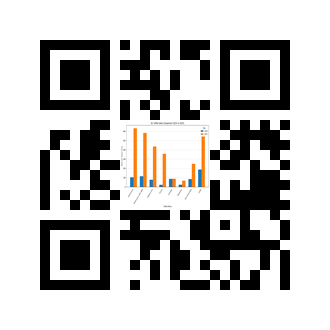

In [91]:
from IPython.display import Image, display

# Display image directly
Image('l_qr_code.png')

In [92]:
prompt = "Can you help me create a qr code that goes to www.NEDAcademy.com from the image chart_v1.png? Also write me a txt note with the current weather please."

response = client.chat.completions.create(
    model="openai:o4-mini",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_weather_from_ip,
        get_current_time,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=10
)

print(response.choices[0].message.content)

I’ve created the QR code (nedacademy_qr.png) linking to www.NEDAcademy.com using chart_v1.png, and drafted a text file (weather_note.txt) with the current weather:

Current weather: 82.1°F  
High: 85.9°F  
Low: 64.0°F  

Let me know if you need anything else!
